# Part I - Extracting CORDEX Climate Data & Formatting into Weather files Format

**Release history**

v0 : 2020-09-15

v1 : 2021-04-27

v2 : 2022-11-05

**License**

Licensed by La Rochelle University/LaSIE & CSTB under a BSD 3 license (https://opensource.org/licenses/BSD-3-Clause).

**To use this code please cite the following publication:**

*Machard, A. , Inard, C., Alessandrini, J.M., Pelé, C., Ribéron, J.
A Methodology for Assembling Future Weather Files Including Heatwaves for Building Thermal Simulations from the European Coordinated Regional Downscaling Experiment (EURO-CORDEX) Climate Data*
https://doi.org/10.3390/en13133424

**Description**

This code extracts CORDEX future climate data projections from NETCDF4 files and converts them into CSV at hourly format

**Data**

Data for this workshop were downloaded from the CORDEX Platform https://cordex.org/

## Importing Python Packages

In [1]:
# Importing Modules
from __future__ import division
import numpy as np
import netCDF4
import pandas as pd
from glob import glob
import xarray as xr
from netCDF4 import num2date
import pvlib
from pvlib.location import Location

## Declaring variables & paths

In [2]:
# Declaring the coordinates of the city point of interest (Here Trappes - rural station for Paris)
# City point must be the exact same one for which observations were collected
lat =  48.77
lon = 2.01
ville = 'Paris-Trappes'
alt = 75

# Inserting path where the .nc files are located
data = r'C:\Users\MACHARD\Downloads\ARTICLES\Weather_Data_Code\ExampleFiles'

# Path where to export the data as csv
path_out = r'C:\Users\MACHARD\Downloads\ARTICLES\Weather_Data_Code'

## Extracting data from NETCDF4 files

In [3]:
# Importing the netcdf files and storing them in files
files = glob(data + "\*.nc") 

In [4]:
# Checking the files have been imported
files

['C:\\Users\\MACHARD\\Downloads\\ARTICLES\\Code Annex80\\ExampleFiles\\clt_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204001010130-204012312230.nc',
 'C:\\Users\\MACHARD\\Downloads\\ARTICLES\\Code Annex80\\ExampleFiles\\clt_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204101010130-204112312230.nc',
 'C:\\Users\\MACHARD\\Downloads\\ARTICLES\\Code Annex80\\ExampleFiles\\huss_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204001010000-204012312100.nc',
 'C:\\Users\\MACHARD\\Downloads\\ARTICLES\\Code Annex80\\ExampleFiles\\huss_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204101010000-204112312100.nc',
 'C:\\Users\\MACHARD\\Downloads\\ARTICLES\\Code Annex80\\ExampleFiles\\ps_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204001010000-204012312100.nc',
 'C:\\Users\\MACHARD\\Downloads\\ARTICLES\\Code Annex80\\ExampleFiles\\ps_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204101010000-204112312100.nc',
 'C:\\Users\\MACHARD\\Downloads\\A

In [5]:
# Functions definitions

def get_name_var(path):
    # Getting the variable name by splitting the caracter chain
    name = path.split("_")[0].split('\\')[-1]
    return name

def get_index(path):
    # Opening the path file as an xarray, getting the time index as a cftime index, converting it to a datetime index
    idx = xr.open_dataset(path).indexes['time'].to_pydatetime()
    return idx

# Variables definitions as empty lists
names, idxs = [], []

for f in files:
    n = get_name_var(f) # Calling the function get_name_var and storing the variables names of all .nc files in "names"
    names.append(n)

for f in files:
    i = get_index(f)  # Calling the function get_index and storing the indexes of all .nc files in "idxs"
    idxs.append(i)

In [6]:
# Printing the list names to make sure it contains all variable names
names

['clt',
 'clt',
 'huss',
 'huss',
 'ps',
 'ps',
 'rsds',
 'rsds',
 'sfcWind',
 'sfcWind',
 'tas',
 'tas']

In [7]:
# Printing the indexes
idxs

[array([datetime.datetime(2040, 1, 1, 1, 30),
        datetime.datetime(2040, 1, 1, 4, 30),
        datetime.datetime(2040, 1, 1, 7, 30), ...,
        datetime.datetime(2040, 12, 31, 16, 30),
        datetime.datetime(2040, 12, 31, 19, 30),
        datetime.datetime(2040, 12, 31, 22, 30)], dtype=object),
 array([datetime.datetime(2041, 1, 1, 1, 30),
        datetime.datetime(2041, 1, 1, 4, 30),
        datetime.datetime(2041, 1, 1, 7, 30), ...,
        datetime.datetime(2041, 12, 31, 16, 30),
        datetime.datetime(2041, 12, 31, 19, 30),
        datetime.datetime(2041, 12, 31, 22, 30)], dtype=object),
 array([datetime.datetime(2040, 1, 1, 0, 0),
        datetime.datetime(2040, 1, 1, 3, 0),
        datetime.datetime(2040, 1, 1, 6, 0), ...,
        datetime.datetime(2040, 12, 31, 15, 0),
        datetime.datetime(2040, 12, 31, 18, 0),
        datetime.datetime(2040, 12, 31, 21, 0)], dtype=object),
 array([datetime.datetime(2041, 1, 1, 0, 0),
        datetime.datetime(2041, 1, 1, 3, 0)

In [8]:
# Printing the lenght of the list to make sure all the file names have been imported
# The list must be the same lenght has the number of files into the data folder
len(names)

12

In [9]:
# Making sure the list of indexes is the same lenght as the list of names (should return the same lenght)
len(idxs)

12

In [10]:
# Function definition
# This function opens the netcdf file, explores it, calculate the distance between each grid point and our city point
# & Gets the variable at the closest point of the grid to our city point

def get_data(file_path, variable, idx, lat=lat, lon=lon):
    
    print('File path:', file_path)
    print('Variable:',variable)
    print('target lat, lon:',lat,lon) 
    # Opening the netCDF4 file and storing it into the variable nc
    nc = netCDF4.Dataset(file_path, mode='r')
    
    # Creating emptly lists of latitudes & longitudes
    list_lat, list_lon = [], []
    
    # Storing all the latitudes of the file in list_lat & all the longitudes in list_lon
    # Iterating through the 2 lists
    for (i,liste) in zip(['lat','lon'],[list_lat,list_lon]):
        # Iterating through the netCDF4 file (nc)
        for liste_i in nc.variables[i][:, :].tolist():
            liste+=[lat for lat in liste_i]

    print('Lenght of list_lat:',len(list_lat),'Length of list_lon:',len(list_lon))
    print('Latitude min/max:',min(list_lat),max(list_lat))
    print('Longitude min/max:',min(list_lon),max(list_lon))
       
    D = 9.E15
    # Creating v, a vector which contains the city point coordinates
    v = np.array([lat, lon])
    
    # Calculating, for each grid point (lat, lon) of the NETCDF4 file, the distance between that point & our city point
    for (lat_i,lon_j) in zip(list_lat,list_lon):
        # Calculating the distance using the function np.linalg.norm which calculates the norm of the vector
        Dij = np.linalg.norm(np.array([lat_i,lon_j]) - v)
        # If the distance is inferior to the distance stored before, we update lat0 & lon0
        # At the end of the loop, once we have compared all distances, the coordinates of the closest grid point 
        # are in lat0, lon0
        if Dij < D:
            lat0,lon0 = lat_i,lon_j
        # Updating D
        D = min(D,Dij)
    # Creating ij0, an array which containts the index of the closest grid point to our city point
    ij0lat = np.where(nc.variables['lat'][:, :]==lat0)
    ij0lon = np.where(nc.variables['lon'][:, :]==lon0)
    
    print('Smallest Distance D:',D)
    print('closest lat, lon:',np.round(lat0,3),np.round(lon0,3))
    # print('ij index:',ij0[0][0],ij0[1][0])
    print('ij0lat index:',ij0lat[0][0])
    print('ij0lon index:',ij0lon[1][0])
    
        
    # Storing in var the variable at the closest grid point to our city point: lat0, lon0
    var = nc.variables[variable][:,ij0lat[0][0], ij0lon[1][0]]
    print('Variable:',var)
        
    # Creating a pandas series that contains the variable associated to its time index
    s = pd.Series(var, index=idx)
        
    # Closing the NetCDF4 file
    nc.close()
    
    # Returnin the variable Series
    return s

## Example : extracting data for one file (tas)

In [13]:
# EXAMPLE for the 2040 Temperature file
dbt = get_data(files[10], names[10], idxs[10],lat,lon)

File path: C:\Users\MACHARD\Downloads\ARTICLES\Code Annex80\ExampleFiles\tas_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204001010000-204012312100.nc
Variable: tas
target lat, lon: 48.77 2.01
Lenght of list_lat: 174688 Length of list_lon: 174688
Latitude min/max: 21.987828756838308 72.5849994760081
Longitude min/max: -44.59386389190011 64.96437666717893
Smallest Distance D: 0.0313479965603623
closest lat, lon: 48.796 2.027
ij0lat index: 205
ij0lon index: 163
Variable: [284.7627  283.8847  282.9122  ... 273.96234 273.75977 273.76315]


In [15]:
# Printing the temperature serie in Kelvin
dbt

2040-01-01 00:00:00    284.762695
2040-01-01 03:00:00    283.884705
2040-01-01 06:00:00    282.912201
2040-01-01 09:00:00    282.941742
2040-01-01 12:00:00    282.653748
                          ...    
2040-12-31 09:00:00    273.528809
2040-12-31 12:00:00    273.721924
2040-12-31 15:00:00    273.962341
2040-12-31 18:00:00    273.759766
2040-12-31 21:00:00    273.763153
Length: 2928, dtype: float32

In [16]:
# Converting Temperature from K to °C
dbt2 = t-273.15

<AxesSubplot:>

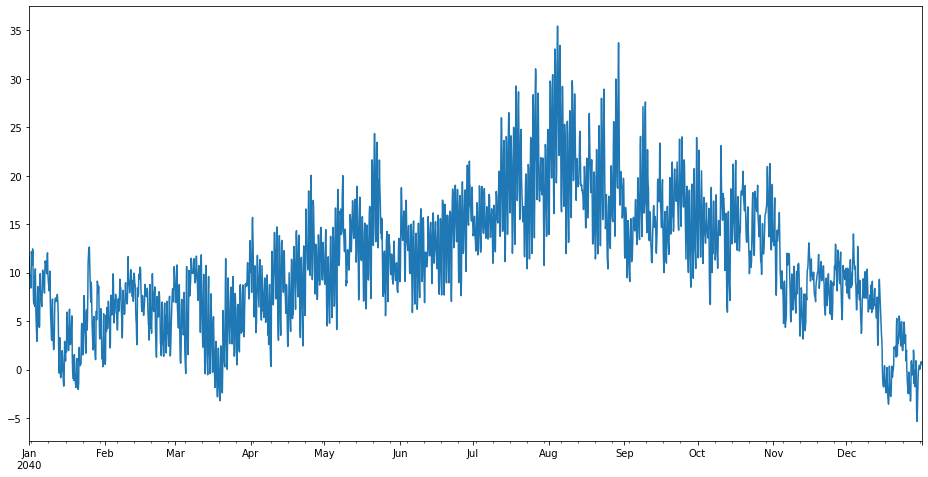

In [17]:
# Plotting Temperature
dbt2.plot(figsize=(16,8))

## Extracting all files data (will take some time if many files)

In [18]:
# Initializing 6 series, one for each weather variable

import datetime
beg = datetime.datetime.now()

S_temp, S_hs, S_wind, S_cc, S_rs, S_pa = pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([])

# Iterating through each .nc file (list files), through each variable (list names), and through each year (list idxs)

for f, n, i in zip (files, names, idxs):
        
# Calling the function get_data
    
    # Storing the series with the data in new
    new = get_data(f, n, i)
        
    print(new.head())
    
    # If the name of the series is tas, it will be added to the series temperature (S_temp)
    if n == 'tas':
        S_temp = S_temp.append(new)
        
    # If the name of the series is clt, it will be added to the series cloud cover (S_cc)
    if n == 'clt':
        S_cc = S_cc.append(new)
    # ...etc
    if n == 'huss':
        S_hs = S_hs.append(new)
    if n == 'ps':
        S_pa = S_pa.append(new)
    if n == 'rsds':
        S_rs = S_rs.append(new)
    if n == 'sfcWind':
        S_wind = S_wind.append(new)


end = datetime.datetime.now()

C:\Users\MACHARD\AppData\Local\Temp/ipykernel_18288/83905795.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  S_temp, S_hs, S_wind, S_cc, S_rs, S_pa = pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([])


File path: C:\Users\MACHARD\Downloads\ARTICLES\Code Annex80\ExampleFiles\clt_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204001010130-204012312230.nc
Variable: clt
target lat, lon: 48.77 2.01
Lenght of list_lat: 174688 Length of list_lon: 174688
Latitude min/max: 21.987828756838308 72.5849994760081
Longitude min/max: -44.59386389190011 64.96437666717893
Smallest Distance D: 0.0313479965603623
closest lat, lon: 48.796 2.027
ij0lat index: 205
ij0lon index: 163
Variable: [ 87.       93.375   100.      ...  93.75     96.4375   99.65625]
2040-01-01 01:30:00     87.00000
2040-01-01 04:30:00     93.37500
2040-01-01 07:30:00    100.00000
2040-01-01 10:30:00     68.46875
2040-01-01 13:30:00      0.78125
dtype: float32
File path: C:\Users\MACHARD\Downloads\ARTICLES\Code Annex80\ExampleFiles\clt_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_3hr_204101010130-204112312230.nc
Variable: clt
target lat, lon: 48.77 2.01
Lenght of list_lat: 174688 Length of list_lon: 174688
Latitude min/

Smallest Distance D: 0.0313479965603623
closest lat, lon: 48.796 2.027
ij0lat index: 205
ij0lon index: 163
Variable: [273.81107 273.7698  273.762   ... 281.47638 280.81897 279.66925]
2041-01-01 00:00:00    273.811066
2041-01-01 03:00:00    273.769806
2041-01-01 06:00:00    273.761993
2041-01-01 09:00:00    273.717163
2041-01-01 12:00:00    274.223511
dtype: float32


In [19]:
# Printing the time needed to export the data
print(beg)
print(end)

2022-11-07 09:38:34.539741
2022-11-07 09:40:15.408362


In [20]:
# Changing some data units.
# Converting temperature from Kelvin to Celcius. 
S_temp = S_temp-273.15
# Converting cloud cover from 1/100 to 1/10 (Tenths)
S_cc = S_cc/10
# Converting humidity data from g/kg to kg/kg.
S_hs = S_hs*1000

In [21]:
# Merging all the data into a dataframe = A table with each variable (series) as a column
df = pd.DataFrame({'tas [C]':S_temp, 'huss [kg/kg]':S_hs, 'sfcWind [m/s]':S_wind, 'rsds [kWh]':S_rs, 'clt [tenths]':S_cc, 'ps [Pa]':S_pa})

In [73]:
## Exporting the data to path_out as .csv
df.to_csv(path_out+'\Part-I_cordex-data.csv', index=True, header=True)

## Formatting & interpolating climate data from 3Hr to 1Hr 

In [23]:
path = path_out+'\Part-I_cordex-data.csv'

In [24]:
## Calling df (if computed in once, df is already known)
df = pd.read_csv(path,index_col=0,header=0)
df.index = pd.to_datetime(df.index)

In [25]:
df

,tas [C],huss [kg/kg],sfcWind [m/s],rsds [kWh],clt [tenths],ps [Pa]
2040-01-01 00:00:00,11.612701,7.781992,5.853060,NaN,NaN,98732.125
2040-01-01 01:30:00,NaN,NaN,NaN,0.000,8.700000,NaN
2040-01-01 03:00:00,10.734711,6.677254,5.395152,NaN,NaN,98940.750
2040-01-01 04:30:00,NaN,NaN,NaN,0.000,9.337500,NaN
2040-01-01 06:00:00,9.762207,7.068665,4.703352,NaN,NaN,99106.500
...,...,...,...,...,...,...
2041-12-31 16:30:00,NaN,NaN,NaN,7.375,9.043750,NaN
2041-12-31 18:00:00,7.668976,4.879663,7.064282,NaN,NaN,97948.500
2041-12-31 19:30:00,NaN,NaN,NaN,0.000,9.218750,NaN
2041-12-31 21:00:00,6.519257,5.044036,6.007293,NaN,NaN,98170.375


In [29]:
# Function to interpolate the temperature every 30 min

def interpolate_30min_poly_temp(s, idx_30min):
    
    # Redindexing the series to 30min time-step and interpolating to 30min time-step
    s_30min = s.reindex(idx_30min).interpolate('polynomial',order=7)

    # Filling the 1st and 2nd values with the 3rd and the last 3 values with the last 4th value
    last = s_30min.iloc[len(s_30min)-4]
    s_30min.iloc[len(s_30min)-3:len(s_30min)] = [last, last, last]
    first = s_30min[2]
    s_30min[0] = first
    s_30min[1] = first
    
    return s_30min

In [30]:
# Defining an index every 30 min
idx_30min = pd.date_range(start='1/1/2040', end='31/12/2041 23:30:00', freq='30min')
# Calling the function
dbt_30min = interpolate_30min_poly_temp(df['tas [C]'], idx_30min)

In [31]:
dbt_30min

2040-01-01 00:00:00    13.367410
2040-01-01 00:30:00    13.367410
2040-01-01 01:00:00    13.367410
2040-01-01 01:30:00    12.944085
2040-01-01 02:00:00    12.215347
                         ...    
2041-12-31 21:30:00          NaN
2041-12-31 22:00:00          NaN
2041-12-31 22:30:00          NaN
2041-12-31 23:00:00          NaN
2041-12-31 23:30:00          NaN
Freq: 30T, Name: tas [C], Length: 35088, dtype: float64

<AxesSubplot:>

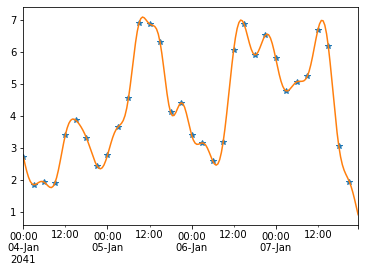

In [32]:
df['tas [C]']['2041-01-04':'2041-01-07'].plot(marker="*")
dbt_30min['2041-01-04':'2041-01-07'].plot()

In [33]:
# Function to interpolate the humidity, wind, atmospheric pressure and cloud cover (linear by default)

def interpolate_30min_linear_hs_wind_pa_cc(s, idx_30min):

    s_30min = s.reindex(idx_30min).interpolate(method='linear')
    # Filling the first 3 missing values
    s_30min[0] = s_30min[3]
    s_30min[1] = s_30min[3]
    s_30min[2] = s_30min[3]
        
    return s_30min

In [34]:
sh_30min = interpolate_30min_linear_hs_wind_pa_cc(df['huss [kg/kg]'], idx_30min)
ws_30min = interpolate_30min_linear_hs_wind_pa_cc(df['sfcWind [m/s]'], idx_30min)
ap_30min = interpolate_30min_linear_hs_wind_pa_cc(df['ps [Pa]'], idx_30min)
cc_30min = interpolate_30min_linear_hs_wind_pa_cc(df['clt [tenths]'], idx_30min)

In [35]:
sh_30min

2040-01-01 00:00:00    7.229623
2040-01-01 00:30:00    7.229623
2040-01-01 01:00:00    7.229623
2040-01-01 01:30:00    7.229623
2040-01-01 02:00:00    7.045500
                         ...   
2041-12-31 21:30:00    5.044036
2041-12-31 22:00:00    5.044036
2041-12-31 22:30:00    5.044036
2041-12-31 23:00:00    5.044036
2041-12-31 23:30:00    5.044036
Freq: 30T, Name: huss [kg/kg], Length: 35088, dtype: float64

<AxesSubplot:>

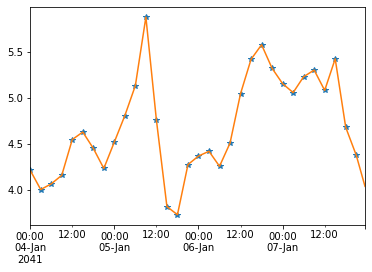

In [36]:
# Plotting specific humidity
df['huss [kg/kg]']['2041-01-04':'2041-01-07'].plot(marker="*")
sh_30min['2041-01-04':'2041-01-07'].plot()

In [37]:
ws_30min

2040-01-01 00:00:00    5.624106
2040-01-01 00:30:00    5.624106
2040-01-01 01:00:00    5.624106
2040-01-01 01:30:00    5.624106
2040-01-01 02:00:00    5.547788
                         ...   
2041-12-31 21:30:00    6.007293
2041-12-31 22:00:00    6.007293
2041-12-31 22:30:00    6.007293
2041-12-31 23:00:00    6.007293
2041-12-31 23:30:00    6.007293
Freq: 30T, Name: sfcWind [m/s], Length: 35088, dtype: float64

<AxesSubplot:>

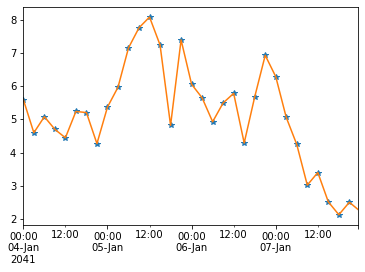

In [38]:
df['sfcWind [m/s]']['2041-01-04':'2041-01-07'].plot(marker="*")
ws_30min['2041-01-04':'2041-01-07'].plot()

<AxesSubplot:>

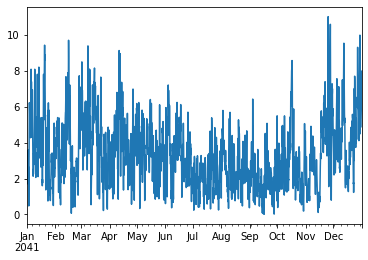

In [39]:
ws_30min['2041'].plot()

<AxesSubplot:>

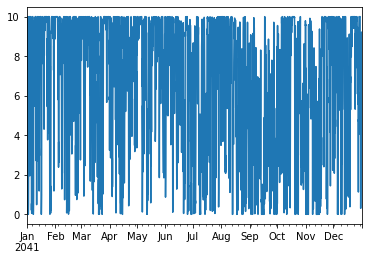

In [40]:
cc_30min['2041'].plot()

<AxesSubplot:>

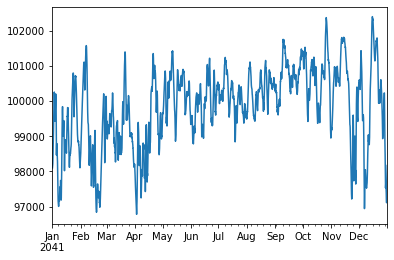

In [41]:
ap_30min['2041'].plot()

In [42]:
# Global Solar Radiation
gsr_30min = df['rsds [kWh]'].reindex(idx_30min)

<AxesSubplot:>

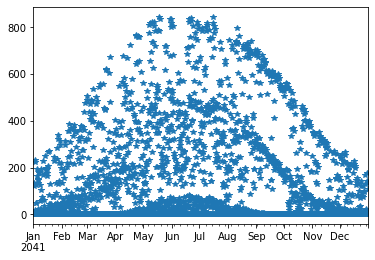

In [43]:
gsr_30min['2041'].plot(marker='*')

<AxesSubplot:>

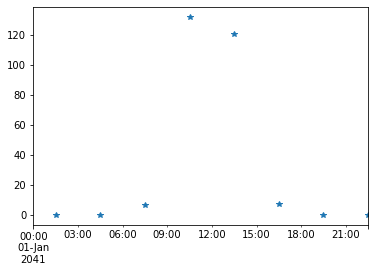

In [44]:
# Winter Day
df['rsds [kWh]']['2041-01-01'].plot(marker="*")

<AxesSubplot:>

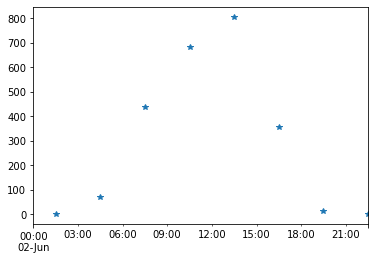

In [45]:
# Summer Day
df['rsds [kWh]']['2041-06-02'].plot(marker="*")

In [46]:
# Getting the sun height from pvlib module
loc = Location(lat, lon, tz='UTC', altitude=alt, name='Paris')
times_loc = idx_30min.tz_localize(loc.pytz, nonexistent='shift_backward', ambiguous=False)
sun_data = pvlib.solarposition.pyephem(times_loc, loc.latitude, loc.longitude)

In [47]:
sun_data

,apparent_elevation,apparent_azimuth,elevation,azimuth,apparent_zenith,zenith
2040-01-01 00:00:00+00:00,-64.258522,2.612211,-64.258522,2.612211,154.258522,154.258522
2040-01-01 00:30:00+00:00,-63.362975,18.150596,-63.362975,18.150596,153.362975,153.362975
2040-01-01 01:00:00+00:00,-61.248820,32.317129,-61.248820,32.317129,151.248820,151.248820
2040-01-01 01:30:00+00:00,-58.169463,44.587482,-58.169463,44.587482,148.169463,148.169463
2040-01-01 02:00:00+00:00,-54.391293,55.009322,-54.391293,55.009322,144.391293,144.391293
...,...,...,...,...,...,...
2041-12-31 21:30:00+00:00,-51.519615,298.829737,-51.519615,298.829737,141.519615,141.519615
2041-12-31 22:00:00+00:00,-55.639995,308.171524,-55.639995,308.171524,145.639995,145.639995
2041-12-31 22:30:00+00:00,-59.216531,319.158867,-59.216531,319.158867,149.216531,149.216531
2041-12-31 23:00:00+00:00,-62.012018,332.049073,-62.012018,332.049073,152.012018,152.012018


In [48]:
gsr_30min

2040-01-01 00:00:00    NaN
2040-01-01 00:30:00    NaN
2040-01-01 01:00:00    NaN
2040-01-01 01:30:00    0.0
2040-01-01 02:00:00    NaN
                      ... 
2041-12-31 21:30:00    NaN
2041-12-31 22:00:00    NaN
2041-12-31 22:30:00    0.0
2041-12-31 23:00:00    NaN
2041-12-31 23:30:00    NaN
Freq: 30T, Name: rsds [kWh], Length: 35088, dtype: float64

In [49]:
# Creating the dataframe df_sun with the global solar radiation rsds and the sun height h
df_sun = pd.DataFrame({'rsds':gsr_30min,'h':sun_data['elevation'].to_list()})

# WARNING: Because the sun values are average values, sometimes there is a data point when the sun is actually down.
# Creating the column gsr sun up in the dataframe
# If the sun height is < 0, gsr sun up = 0, otherwise gsr sun up = gsr
df_sun['rsds sun up'] = np.where(df_sun['h']<0,0,df_sun['rsds'])

# Creating the column gsr final up in the dataframe
# Interpolating from 3Hour to 30min
df_sun['rsds final'] = df_sun['rsds sun up'].interpolate(method='polynomial', order=2) 

<AxesSubplot:>

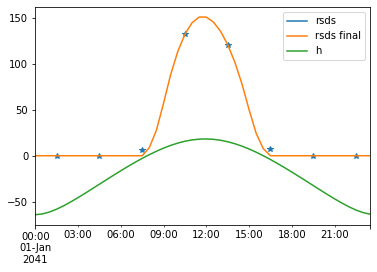

In [50]:
# Check for a winter day
df_sun['rsds']['2041-01-01'].plot(marker="*", legend=True)
df_sun['rsds final']['2041-01-01'].plot(legend=True)
df_sun['h']['2041-01-01'].plot(legend=True)

<AxesSubplot:>

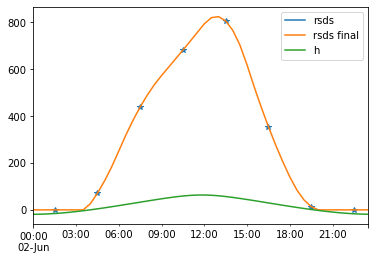

In [51]:
# Check for a summer day
df_sun['rsds']['2041-06-02'].plot(marker="*", legend=True)
df_sun['rsds final']['2041-06-02'].plot(legend=True)
df_sun['h']['2041-06-02'].plot(legend=True)

In [52]:
# Creating a dataframe with all data series
df_30min = pd.DataFrame({'tas [C]':dbt_30min, 'huss [kg/kg]':sh_30min, 'sfcWind [m/s]':ws_30min, 'ps [Pa]':ap_30min, 'clt [tenths]':cc_30min, 'rsds [kwh]':df_sun['rsds final'].to_list()})

In [53]:
df_30min

,tas [C],huss [kg/kg],sfcWind [m/s],ps [Pa],clt [tenths],rsds [kwh]
2040-01-01 00:00:00,13.367410,7.229623,5.624106,98836.437500,8.700000,0.0
2040-01-01 00:30:00,13.367410,7.229623,5.624106,98836.437500,8.700000,0.0
2040-01-01 01:00:00,13.367410,7.229623,5.624106,98836.437500,8.700000,0.0
2040-01-01 01:30:00,12.944085,7.229623,5.624106,98836.437500,8.700000,0.0
2040-01-01 02:00:00,12.215347,7.045500,5.547788,98871.208333,8.806250,0.0
...,...,...,...,...,...,...
2041-12-31 21:30:00,NaN,5.044036,6.007293,98170.375000,7.841667,0.0
2041-12-31 22:00:00,NaN,5.044036,6.007293,98170.375000,7.497396,0.0
2041-12-31 22:30:00,NaN,5.044036,6.007293,98170.375000,7.153125,0.0
2041-12-31 23:00:00,NaN,5.044036,6.007293,98170.375000,7.153125,0.0


In [54]:
## Reindexing to 1HR
df_1H = df_30min.iloc[::2] 

In [55]:
df_1H

,tas [C],huss [kg/kg],sfcWind [m/s],ps [Pa],clt [tenths],rsds [kwh]
2040-01-01 00:00:00,13.367410,7.229623,5.624106,98836.437500,8.700000,0.0
2040-01-01 01:00:00,13.367410,7.229623,5.624106,98836.437500,8.700000,0.0
2040-01-01 02:00:00,12.215347,7.045500,5.547788,98871.208333,8.806250,0.0
2040-01-01 03:00:00,10.734711,6.677254,5.395152,98940.750000,9.018750,0.0
2040-01-01 04:00:00,9.855458,6.807724,5.164552,98996.000000,9.231250,0.0
...,...,...,...,...,...,...
2041-12-31 19:00:00,8.187992,4.934454,6.711952,98022.458333,9.189583,0.0
2041-12-31 20:00:00,8.422246,4.989245,6.359623,98096.416667,8.874479,0.0
2041-12-31 21:00:00,6.519257,5.044036,6.007293,98170.375000,8.185937,0.0
2041-12-31 22:00:00,NaN,5.044036,6.007293,98170.375000,7.497396,0.0


In [56]:
# Calculating the vapor pressure
df_1H['pv'] = ((df_1H['huss [kg/kg]']/1000*df_1H['ps [Pa]']/100)/(0.62198+df_1H['huss [kg/kg]']/1000)) # PV is en hASP or mBar

# Calculating the saturated vapor pressure
df_1H.loc[df_1H['tas [C]'] < 0, 'svp'] = 6.105 * np.exp((21.875*df_1H['tas [C]'])/(265.5+df_1H['tas [C]']))
df_1H.loc[df_1H['tas [C]'] > 0, 'svp'] = 6.105 * np.exp((17.269*df_1H['tas [C]'])/(237.3+df_1H['tas [C]']))

# Calculating the Relative Humidity in percentage
df_1H['hurs [%]'] = df_1H['pv']/df_1H ['svp']*100

C:\Users\MACHARD\AppData\Local\Temp/ipykernel_18288/3018333897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1H['pv'] = ((df_1H['huss [kg/kg]']/1000*df_1H['ps [Pa]']/100)/(0.62198+df_1H['huss [kg/kg]']/1000)) # PV is en hASP or mBar
C:\Users\MACHARD\Anaconda3\lib\site-packages\pandas\core\indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
C:\Users\MACHARD\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to 

In [57]:
df_1H['pv']

2040-01-01 00:00:00    11.356313
2040-01-01 01:00:00    11.356313
2040-01-01 02:00:00    11.074226
2040-01-01 03:00:00    10.508946
2040-01-01 04:00:00    10.718044
                         ...    
2041-12-31 19:00:00     7.715364
2041-12-31 20:00:00     7.806237
2041-12-31 21:00:00     7.897224
2041-12-31 22:00:00     7.897224
2041-12-31 23:00:00     7.897224
Freq: 60T, Name: pv, Length: 17544, dtype: float64

In [58]:
df_1H['svp']

2040-01-01 00:00:00    15.333145
2040-01-01 01:00:00    15.333145
2040-01-01 02:00:00    14.218364
2040-01-01 03:00:00    12.890548
2040-01-01 04:00:00    12.154736
                         ...    
2041-12-31 19:00:00    10.860119
2041-12-31 20:00:00    11.034329
2041-12-31 21:00:00     9.687611
2041-12-31 22:00:00          NaN
2041-12-31 23:00:00          NaN
Freq: 60T, Name: svp, Length: 17544, dtype: float64

In [59]:
df_1H['hurs [%]']

2040-01-01 00:00:00    74.063820
2040-01-01 01:00:00    74.063820
2040-01-01 02:00:00    77.886779
2040-01-01 03:00:00    81.524429
2040-01-01 04:00:00    88.179984
                         ...    
2041-12-31 19:00:00    71.043088
2041-12-31 20:00:00    70.745012
2041-12-31 21:00:00    81.518800
2041-12-31 22:00:00          NaN
2041-12-31 23:00:00          NaN
Freq: 60T, Name: hurs [%], Length: 17544, dtype: float64

<AxesSubplot:>

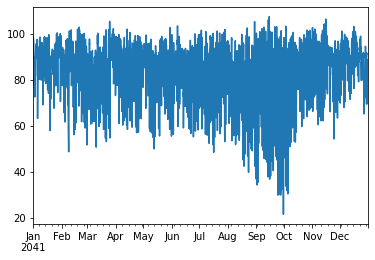

In [60]:
df_1H['hurs [%]']['2041'].plot()

In [61]:
del df_1H['pv']
del df_1H['svp']

In [62]:
df_1H

,tas [C],huss [kg/kg],sfcWind [m/s],ps [Pa],clt [tenths],rsds [kwh],hurs [%]
2040-01-01 00:00:00,13.367410,7.229623,5.624106,98836.437500,8.700000,0.0,74.063820
2040-01-01 01:00:00,13.367410,7.229623,5.624106,98836.437500,8.700000,0.0,74.063820
2040-01-01 02:00:00,12.215347,7.045500,5.547788,98871.208333,8.806250,0.0,77.886779
2040-01-01 03:00:00,10.734711,6.677254,5.395152,98940.750000,9.018750,0.0,81.524429
2040-01-01 04:00:00,9.855458,6.807724,5.164552,98996.000000,9.231250,0.0,88.179984
...,...,...,...,...,...,...,...
2041-12-31 19:00:00,8.187992,4.934454,6.711952,98022.458333,9.189583,0.0,71.043088
2041-12-31 20:00:00,8.422246,4.989245,6.359623,98096.416667,8.874479,0.0,70.745012
2041-12-31 21:00:00,6.519257,5.044036,6.007293,98170.375000,8.185937,0.0,81.518800
2041-12-31 22:00:00,NaN,5.044036,6.007293,98170.375000,7.497396,0.0,NaN


## Exporting data to CSV

In [76]:
# WARNING: The data are in UTC
df_1H.to_csv(path_out + '/'+'Part-I_hourly-weather-data-cordex.csv', index=True, header=True)

<AxesSubplot:>

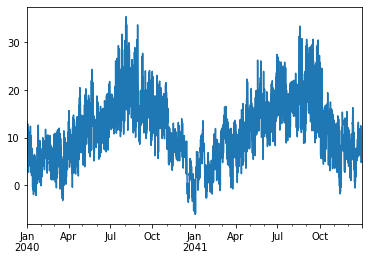

In [64]:
df_1H['tas [C]'].plot()

<AxesSubplot:>

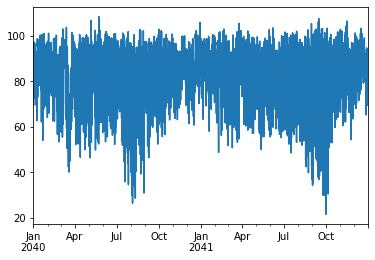

In [65]:
df_1H['hurs [%]'].plot()

<AxesSubplot:>

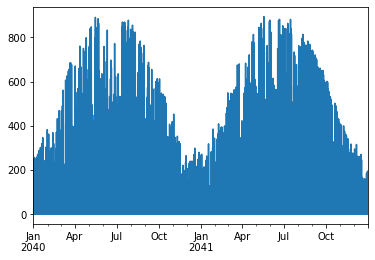

In [66]:
df_1H['rsds [kwh]'].plot()

<AxesSubplot:>

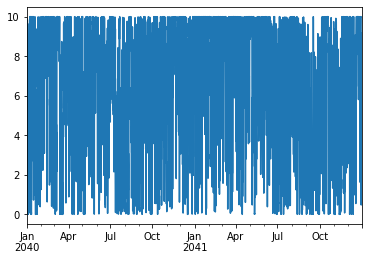

In [67]:
df_1H['clt [tenths]'].plot()

<AxesSubplot:>

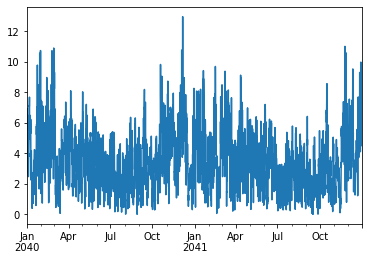

In [68]:
df_1H['sfcWind [m/s]'].plot()

<AxesSubplot:>

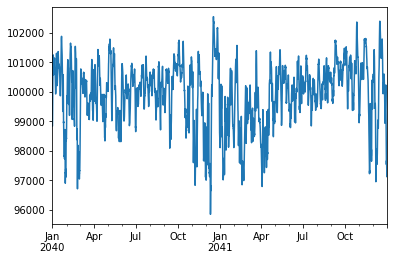

In [69]:
df_1H['ps [Pa]'].plot()